In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
Xy_numu = np.load("Xy_numu_sel5.npz")
Xy_nue = np.load("Xy_nue.sel5.npz")

In [3]:
X_numu = Xy_numu["x"]
X_nue = Xy_nue["x"]

In [4]:
y_numu = Xy_numu["y"]
y_nue = Xy_nue["y"]

In [5]:
updown_numu = np.load("updown_numu_sel5.npz")
updown_nue = np.load("updown_nue_sel5.npz")

In [6]:
upgoing_numu_indx = updown_numu["up"]
downgoing_numu_indx = updown_numu[ "down"]

upgoing_nue_indx = updown_nue["up"]
downgoing_nue_indx = updown_nue[ "down"]

In [7]:
np.unique(upgoing_numu_indx).shape

(642,)

In [8]:
np.unique(downgoing_numu_indx).shape

(439,)

upgoing_numu_indx, downgoing_numu_indx = sel_up_down(numu_file,"numu")

upgoing_nue_indx, downgoing_nue_indx = sel_up_down(nue_file, "nue")

In [9]:
X_numu_up = X_numu[upgoing_numu_indx]
y_numu_up = y_numu[upgoing_numu_indx]

In [10]:
X_numu_down = X_numu[downgoing_numu_indx]
y_numu_down = y_numu[downgoing_numu_indx]

In [11]:
X_nue_up = X_nue[upgoing_nue_indx]
y_nue_up = y_nue[upgoing_nue_indx]

X_nue_down = X_nue[downgoing_nue_indx]
y_nue_down = y_nue[downgoing_nue_indx]

In [13]:
np.all(y_numu_up==1)

True

In [14]:
np.all(y_nue_up==0)

True

In [15]:
y_nue_up = y_nue_up+1

In [16]:
np.all(y_nue_up==1)

True

In [17]:
np.all(y_numu_down==1)

True

In [18]:
y_numu_down = 0*y_numu_down

In [19]:
np.all(y_numu_down==0)

True

In [20]:
np.all(y_nue_down==0)

True

In [21]:
print('X_numu_up: ', X_numu_up.shape, 'X_nue_up: ', X_nue_up.shape, 'y_numu_up: ', y_numu_up.shape, 'y_nue_up: ', y_nue_up.shape)

('X_numu_up: ', (642, 75, 16, 15, 18), 'X_nue_up: ', (415, 75, 16, 15, 18), 'y_numu_up: ', (642,), 'y_nue_up: ', (415,))


In [22]:
print('X_numu_down: ', X_numu_down.shape, 'X_nue_down: ', X_nue_down.shape, 'y_numu_down: ', y_numu_down.shape, 'y_nue_down: ', y_nue_down.shape)

('X_numu_down: ', (439, 75, 16, 15, 18), 'X_nue_down: ', (355, 75, 16, 15, 18), 'y_numu_down: ', (439,), 'y_nue_down: ', (355,))


In [23]:
X_up = np.vstack((X_numu_up, X_nue_up))

In [24]:
y_up = np.hstack((y_numu_up, y_nue_up))

In [25]:
X_down = np.vstack((X_numu_down, X_nue_down))

In [26]:
y_down = np.hstack((y_numu_down, y_nue_down))

In [27]:
X = np.vstack((X_up,X_down))

In [28]:
y = np.hstack((y_up,y_down))

In [29]:
print(X.shape, y.shape)

((1851, 75, 16, 15, 18), (1851,))


In [30]:
np.all(y_up==1)

True

In [31]:
np.all(y_down==0)

True

In [32]:
import keras

Using TensorFlow backend.


In [33]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [34]:
get_available_gpus()

[u'/gpu:0', u'/gpu:1']

In [35]:
keras.backend.image_data_format()

'channels_first'

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [37]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
from keras.layers import ConvLSTM2D, TimeDistributed
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import categorical_crossentropy

In [39]:
from history_plot import history_plot, history_plot_cv

In [40]:
print("X size: %d, y size: %d" %(X.shape[0], y.shape[0]) )

X size: 1851, y size: 1851


In [41]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, indx_train, indx_test = train_test_split(X, y, indices, test_size=0.20, 
                                                                           random_state=42, stratify=y)

In [42]:
print(X_train.shape, y_train.shape, indx_train.shape)
print(X_test.shape, y_test.shape, indx_test.shape)

((1480, 75, 16, 15, 18), (1480,), (1480,))
((371, 75, 16, 15, 18), (371,), (371,))


In [43]:
# Check that Stratification worked
print(y[y==0].shape, y_train[y_train==0].shape, y_test[y_test==0].shape)
print(y[y==1].shape, y_train[y_train==1].shape, y_test[y_test==1].shape)

((794,), (635,), (159,))
((1057,), (845,), (212,))


In [44]:
from collections import Counter

def get_class_weights(y):
    if y.ndim == 2:
        y = np.argmax(y, axis=1)
    counter = Counter(y)
    majority = max(counter.values())
    return {cls: float(majority/count) for cls, count in counter.items()}

cls_weights = get_class_weights(y_train)

In [45]:
img_channel = X_train.shape[1]
conv_dim_1 = X_train.shape[2]
conv_dim_2 = X_train.shape[3]
conv_dim_3 = X_train.shape[4]
inputshape = (img_channel, conv_dim_1, conv_dim_2, conv_dim_3)
print(inputshape)

(75, 16, 15, 18)


##### Setup Model Callbacks

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)
reduce_lr_noval = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

#### Create Deep Network Model

In [91]:
def cnn_model_lstm(num_classes, optimizer):
    model = Sequential()
    model.add(ConvLSTM2D(128, kernel_size=(3, 3), activation='relu', input_shape=inputshape, return_sequences=True))
    #model.add(ConvLSTM2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))
    #model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    #model.add(Dropout(0.25))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [47]:
def cnn_model_tdist(num_classes, optimizer):
    model = Sequential()
    model.add(TimeDistributed(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'), input_shape=inputshape))
    model.add(TimeDistributed(Conv3D(64, (3, 3, 3), activation='relu')))
    #model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))
    model.add(TimeDistributed(Conv3D(32, (3, 3, 3), activation='relu')))
    model.add(Dropout(0.25))
    #model.add(TimeDistributed(Conv3D(32, (3, 3, 3), activation='relu')))
    
    model.add(Flatten())
    #model.add(Dense(256,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model
X_train_tdist = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], X_train.shape[3], X_train.shape[4])
print(X_train_tdist.shape)
img_channel = X_train_tdist.shape[2]
time_dim = X_train_tdist.shape[1]
conv_dim_1 = X_train_tdist.shape[3]
conv_dim_2 = X_train_tdist.shape[4]
conv_dim_3 = X_train_tdist.shape[5]
inputshape = (time_dim, img_channel, conv_dim_1, conv_dim_2, conv_dim_3)
print(inputshape)

(1480, 75, 1, 16, 15, 18)
(75, 1, 16, 15, 18)


In [55]:
def cnn_model(num_classes, optimizer):
    model = Sequential()
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', input_shape=inputshape))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [48]:
from keras.backend import clear_session

def cross_validation_score(K, N, X_train, y_train, f_model, f_args, fit_args):
    """"""
    iteration_tr_score = list()
    iteration_val_score = list()
    histories_cnn = list()
    
    def iteration_metrics(scores):
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        return mean_score, min_score, max_score
    
    for iteration in range(N):
        tr_accuracy_scores = list()
        val_accuracy_scores=list()
        
        skf = StratifiedKFold(n_splits=K, random_state=iteration)
        
        for i, (train_index, validation_index) in enumerate(skf.split(X_train, y_train)):
            print("[Iteration %d/%d] Test nr.: %d/%d" % (iteration+1, N, i+1, K))
            
            Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
            ytrain, yvalidation = y_train[train_index], y_train[validation_index]

            model = f_model(**f_args)
            
            if iteration == 0 and i == 0:
                model.summary()
            
            Ytrain = to_categorical(ytrain)
            Yvalidation = to_categorical(yvalidation)
            history = model.fit(Xtrain, Ytrain, validation_data = (Xvalidation, Yvalidation), 
                                shuffle=False, **fit_args) 
                        
            histories_cnn.append(history)
            training_acc = history.history['acc'][-1]
            validation_acc = history.history['val_acc'][-1]
            
            print("\nTraining acc: %f, Validation acc: %f\n" %(training_acc,validation_acc))
            tr_accuracy_scores.append(training_acc)
            val_accuracy_scores.append(validation_acc)
            
        iteration_tr_score.append(iteration_metrics(tr_accuracy_scores))
        iteration_val_score.append(iteration_metrics(val_accuracy_scores))
        
    clear_session()
        
    print("Training metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_tr_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))
    
    print("Validation metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_val_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))

    return histories_cnn

In [57]:
clear_session()

In [60]:
n_splits = 3
n_iterations = 2
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 8, 'epochs': 30, 'verbose': 1,'callbacks': [early_stop], 'class_weight': cls_weights}, 
history_info = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train_tdist, y_train=y_train, 
                                      f_model=cnn_model_tdist, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 75, 128, 14, 13, 1 3584      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 75, 64, 12, 11, 14 221248    
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 64, 12, 11, 14 0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 75, 32, 10, 9, 12) 55328     
_________________________________________________________________
dropout_6 (Dropout)          (None, 75, 32, 10, 9, 12) 0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2592000)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)        

TypeError: fit() argument after ** must be a mapping, not tuple

In [195]:
import history_plot
reload(history_plot)
len(history_info)

6

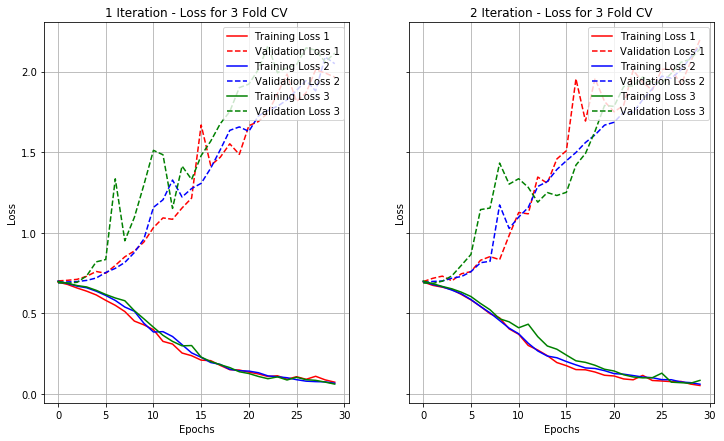

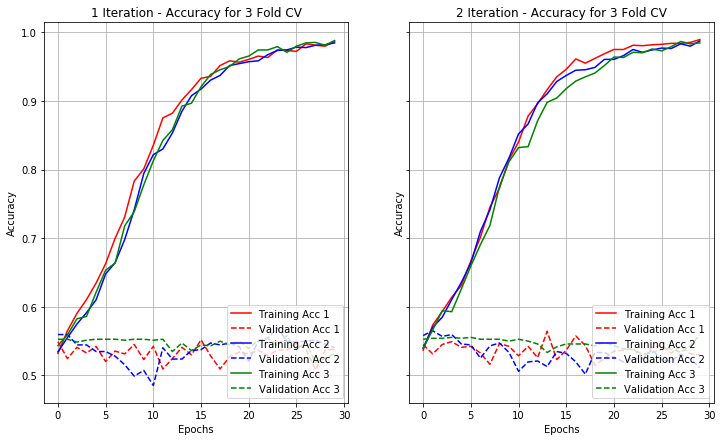

In [196]:
 %matplotlib inline
history_plot.history_plot_cv(history_info,"", "show", K=n_splits, N=n_iterations)

In [27]:
Ytrain = to_categorical(y_train)
batch = 64
epochs = 30
print("Train model on the whole train dataset - no validation")
model=cnn_model(num_classes= 2, optimizer=keras.optimizers.Adadelta())
repl_history = model.fit(X_train, Ytrain, batch_size=batch, epochs=epochs, callbacks=[early_stop_noval])  # replicate conf.


Train model on the whole train dataset - no validation
Epoch 1/30
2052/2052 [==============================] - 6s - loss: 0.6731 - acc: 0.5824     
Epoch 2/30
2052/2052 [==============================] - 6s - loss: 0.5629 - acc: 0.6613     
Epoch 3/30
2052/2052 [==============================] - 6s - loss: 0.3683 - acc: 0.8762     
Epoch 4/30
2052/2052 [==============================] - 5s - loss: 0.2651 - acc: 0.9020     
Epoch 5/30
2052/2052 [==============================] - 6s - loss: 0.2291 - acc: 0.9162     
Epoch 6/30
2052/2052 [==============================] - 6s - loss: 0.1792 - acc: 0.9313     
Epoch 7/30
2052/2052 [==============================] - 5s - loss: 0.1652 - acc: 0.9401     
Epoch 8/30
2052/2052 [==============================] - 6s - loss: 0.1554 - acc: 0.9493     
Epoch 9/30
2052/2052 [==============================] - 5s - loss: 0.1340 - acc: 0.9522     
Epoch 10/30
2052/2052 [==============================] - 5s - loss: 0.1206 - acc: 0.9581     
Epoch 11/30
20

In [200]:
print("Use model to make prediction on test data")
predictions = cnn_model(num_classes=2, optimizer=keras.optimizers.Adadelta()).predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.46972477064220186)


In [201]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
wrong_class_evt = indx_test[np.where(cls_predictions!=y_test)]
print(wrong_class_evt)
print("{} misclassified events out of {} --> {}%".format(wrong_class_evt.size,y_test.size,
                                                            np.true_divide((y_test.size-wrong_class_evt.size),y_test.size)))


Confusion matrix: 
[[225  19]
 [270  31]]
indices of the wrongly classified events: 
[ 689 1382  824 1905 1175 1085 1006  948 1132 2537  400 1181 1122 2156 2326
  709  712 1455  806  274  244  271 1112  893  720  696 1415  687  136 1136
  614  660   41 1297  743 1301  578 1410  721 1346 1892  853 1121 2461  217
    3    6  750 1312 1336   58 1380  688  153  236  551 1101 1070 2518 1924
   33 1494  921  710  129  310 1138  431  260  706   60  563  925  488   46
  777 1848 1223 1430 1393 1383  865   40 1360  884 1169  373  816  745  905
  413   72 1345 1291  939  593  882  525  470  963  327  215 1252  150 1104
 1109  265  708  317  182  523 1182  441   10 1077  663   26  771  822 1267
  982  329 2385 1423  186  730  956 1130 1176 1067 2657 1488  496 1193   11
 1250  645 1165  395  363 1304  250  981 1184  699  334 1401  757  167  181
   28   97  371  364  323 2522 1262 2382  145  735 1277  200  631  933  619
  622 1171  747 1164  375   53  490  513 1441  592 1108 1019   74 2569  476
 12

In [205]:
wrong_class_evt_up = wrong_class_evt[wrong_class_evt<X_up.shape[0]]

In [206]:
wrong_class_evt_down = wrong_class_evt[wrong_class_evt>X_up.shape[0]] - X_up.shape[0]

In [208]:
print(wrong_class_evt_up, wrong_class_evt_down)

(array([ 689, 1382,  824, 1175, 1085, 1006,  948, 1132,  400, 1181, 1122,
        709,  712, 1455,  806,  274,  244,  271, 1112,  893,  720,  696,
       1415,  687,  136, 1136,  614,  660,   41, 1297,  743, 1301,  578,
       1410,  721, 1346,  853, 1121,  217,    3,    6,  750, 1312, 1336,
         58, 1380,  688,  153,  236,  551, 1101, 1070,   33, 1494,  921,
        710,  129,  310, 1138,  431,  260,  706,   60,  563,  925,  488,
         46,  777, 1223, 1430, 1393, 1383,  865,   40, 1360,  884, 1169,
        373,  816,  745,  905,  413,   72, 1345, 1291,  939,  593,  882,
        525,  470,  963,  327,  215, 1252,  150, 1104, 1109,  265,  708,
        317,  182,  523, 1182,  441,   10, 1077,  663,   26,  771,  822,
       1267,  982,  329, 1423,  186,  730,  956, 1130, 1176, 1067, 1488,
        496, 1193,   11, 1250,  645, 1165,  395,  363, 1304,  250,  981,
       1184,  699,  334, 1401,  757,  167,  181,   28,   97,  371,  364,
        323, 1262,  145,  735, 1277,  200,  631,  

In [43]:
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"

In [44]:
import ROOT
import root_numpy as rnp

In [46]:
E_numu = rnp.root2array(numufile, treename='E', branches='Evt.mc_trks.E')
type_numu = rnp.root2array(numufile, treename='E', branches = 'Evt.mc_trks.type')
E_nue = rnp.root2array(nuefile, treename='E', branches='Evt.mc_trks.E')
type_nue = rnp.root2array(nuefile, treename='E', branches = 'Evt.mc_trks.type')


E_numu_ = np.asarray([E_numu[evt][type_numu[evt]==5][0]for evt in range(E_numu.shape[0])])

E_nue_ = np.asarray([E_nue[evt][type_nue[evt]==3][0]for evt in range(E_nue.shape[0])])


In [47]:
E_numu_[wrong_class_evt_numu]
E_nue_[wrong_class_evt_nue]

array([  1.14757000e+05,   9.78496000e+02,   4.98240000e+02,
         4.93355000e+03,   1.57173000e+03,   7.32269000e+02,
         1.32913000e+03,   1.12715000e+03,   2.95633000e+04,
         1.35398000e+03,   1.39607000e+05,   1.47301000e+04,
         2.74210000e+03,   8.85677000e+03,   9.91460000e+01,
         3.32351000e+02,   1.91114000e+04])

In [48]:
nbins = 12
log_MC_en = np.log10(E_numu_) 
log_minE = np.min(log_MC_en) #np.log10(np.int(np.min(montecarlo_energies)))
log_maxE = np.max(log_MC_en) #np.log10(np.int(np.max(montecarlo_energies)))
        
log_evts = np.log10(wrong_class_evt_numu) 
    #binned log energies calculation with np.histogram
MC_events_per_bin, _ = np.histogram(log_MC_en, bins=nbins, range=(log_minE, log_maxE))
wrong_evts_per_bin, energy_bins = np.histogram(log_evts, bins=nbins, range=(log_minE,log_maxE))

In [49]:
fraction = np.true_divide(wrong_evts_per_bin, MC_events_per_bin)

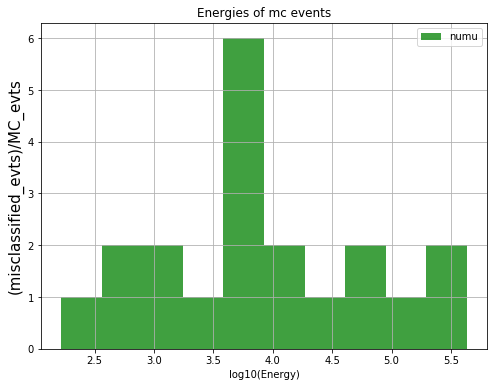

In [50]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(np.log10(E_numu_[wrong_class_evt_numu]), normed=False, facecolor='g', alpha=0.75, label="numu")
#plt.hist(np.log10(E_nue_[wrong_class_evt_nue]), normed=False,  facecolor="blue", alpha=0.5, label="nue")
#plt.hist(np.log10(E_numu_), normed=False, facecolor='b', alpha=0.5, label="numu")
#plt.plot(energy_bins[1:], fraction)

#plt.hist(np.log10(E_numu_), bins=energy_bins)
plt.xlabel("log10(Energy)")
plt.ylabel("(misclassified_evts)/MC_evts", size=15)
plt.xscale("linear")
plt.title('Energies of mc events')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [21]:
i=[]
j=[]
k=[]
for ii,x in enumerate(range(-300,1100,90)):
    for jj,y in enumerate(np.arange(-550,550, 45*np.sqrt(3))):
        for kk,z in enumerate(range(98,712,36)):
            i.append(ii)
            j.append(jj)
            k.append(kk)
        x-= 45
l_i = np.asarray(i)
l_j = np.asarray(j)
l_k = np.asarray(k)


arr = []
for i,j,k in zip(l_i,l_j,l_k):
    arr.append((i,j,k))
lol = np.asarray(arr)



In [22]:
def plot_x_evt(evt):
    ggg = np.sum(X_numu[evt], axis=0)
    hhh = np.nonzero(ggg)
    return ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9)


In [53]:
wrong_class_evt_numu

array([ 675,  587,  799, 1283,  713,  525,  470,  551, 1013,  215,  441,
        875, 1003, 1491, 1076,  730,   14,   46, 1101,   40])

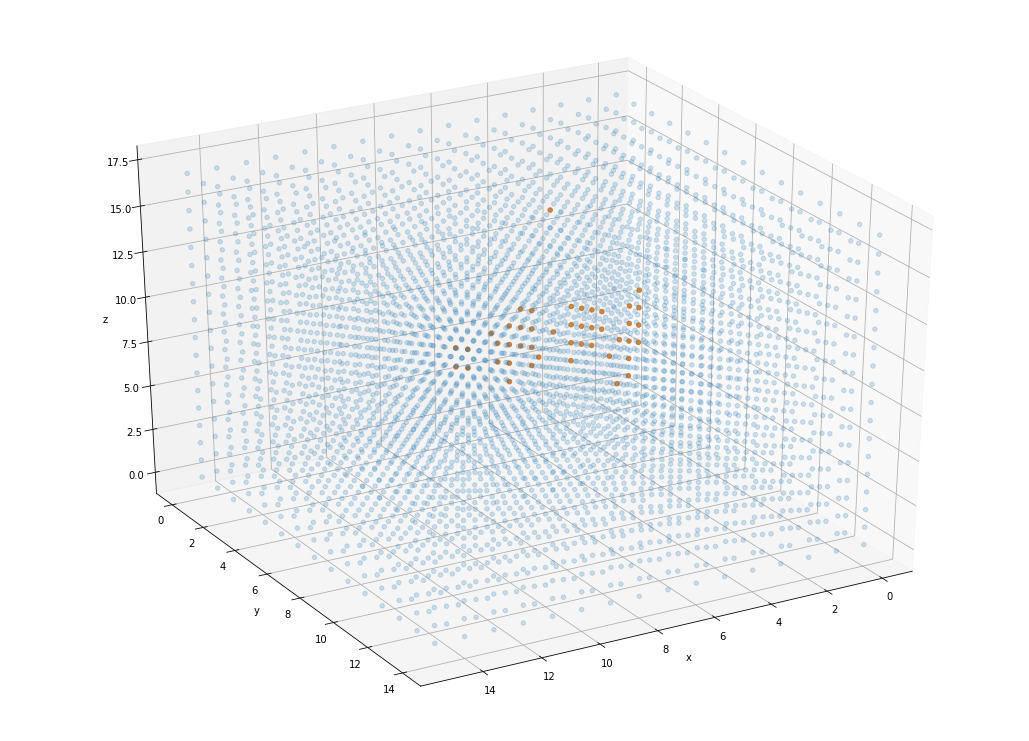

In [58]:
% matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,10))
ax = Axes3D(fig)

ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#for evt in wrong_class_evt_numu:
#    plot_x_evt(evt)
plot_x_evt(610)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()


In [84]:
Xy_numu2 = np.load("Xy_numu2_sel5.npz")
Xy_nue2 = np.load("Xy_nue2_sel5.npz")


X_numu2 = Xy_numu2["x"]
y_numu2 = Xy_numu2["y"]


X_nue2 = Xy_nue2["x"]
y_nue2 = Xy_nue2["y"]



In [85]:
print('X_numu2: ', X_numu2.shape, 'X_nue2: ', X_nue2.shape, 'y_num2u: ', y_numu2.shape, 'y_nue2: ', y_nue2.shape)

('X_numu2: ', (1533, 75, 16, 15, 18), 'X_nue2: ', (1104, 75, 16, 15, 18), 'y_num2u: ', (1533,), 'y_nue2: ', (1104,))


In [86]:
X2 = np.vstack((X_numu2, X_nue2))
y2 = np.hstack((y_numu2, y_nue2))

In [60]:
np.random.shuffle?

In [87]:
indices = range(y2.size)

In [89]:
np.random.shuffle(indices)

In [90]:
sh_X2 = X2[indices]

In [91]:
sh_y2 = y2[indices]

In [92]:
sh_y2[:10]

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0], dtype=uint8)

In [94]:
print("Use model to make prediction on new data")
predictions = model.predict(sh_X2)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(sh_y2, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on new data
('Accuracy score: ', 0.8555176336746303)


In [102]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(sh_y2, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
wrong_class_evt = np.where(cls_predictions!=sh_y2)[0]
print(wrong_class_evt)
print("{} misclassified events out of {} --> {}%".format(wrong_class_evt.size,sh_y2.size,
                                                            np.true_divide((sh_y2.size-wrong_class_evt.size),sh_y2.size)))


Confusion matrix: 
[[1042   62]
 [ 319 1214]]
indices of the wrongly classified events: 
[   0    1    2    6   16   18   46   47   49   66   75   95  103  106  107
  110  114  122  124  128  129  136  153  164  176  198  208  211  220  222
  226  227  228  240  245  250  260  274  277  279  280  283  291  299  300
  308  312  333  342  347  350  352  353  354  359  368  442  444  455  459
  461  467  469  480  492  497  499  504  506  509  512  519  523  524  536
  542  546  548  560  567  569  577  582  585  588  589  590  595  596  598
  600  602  603  630  631  632  635  638  650  651  673  685  687  688  689
  696  720  724  730  733  734  737  756  763  782  791  792  793  797  798
  799  807  822  825  827  831  832  844  846  849  862  865  869  874  883
  904  906  910  917  925  926  936  948  952  957  962  969  970  971  978
  992  993 1005 1010 1014 1015 1018 1019 1027 1028 1029 1036 1050 1054 1063
 1067 1090 1095 1115 1136 1150 1160 1162 1176 1182 1191 1192 1195 1202 1204

In [103]:
wrong_class_evt_numu2 = wrong_class_evt[wrong_class_evt<X_numu2.shape[0]]


wrong_class_evt_nue2 = wrong_class_evt[wrong_class_evt>X_numu2.shape[0]] - X_numu2.shape[0]




In [104]:
wrong_class_evt_numu2

array([   0,    1,    2,    6,   16,   18,   46,   47,   49,   66,   75,
         95,  103,  106,  107,  110,  114,  122,  124,  128,  129,  136,
        153,  164,  176,  198,  208,  211,  220,  222,  226,  227,  228,
        240,  245,  250,  260,  274,  277,  279,  280,  283,  291,  299,
        300,  308,  312,  333,  342,  347,  350,  352,  353,  354,  359,
        368,  442,  444,  455,  459,  461,  467,  469,  480,  492,  497,
        499,  504,  506,  509,  512,  519,  523,  524,  536,  542,  546,
        548,  560,  567,  569,  577,  582,  585,  588,  589,  590,  595,
        596,  598,  600,  602,  603,  630,  631,  632,  635,  638,  650,
        651,  673,  685,  687,  688,  689,  696,  720,  724,  730,  733,
        734,  737,  756,  763,  782,  791,  792,  793,  797,  798,  799,
        807,  822,  825,  827,  831,  832,  844,  846,  849,  862,  865,
        869,  874,  883,  904,  906,  910,  917,  925,  926,  936,  948,
        952,  957,  962,  969,  970,  971,  978,  9

In [106]:
def plot_x_evt(evt):
    ggg = np.sum(X_numu2[evt], axis=0)
    hhh = np.nonzero(ggg)
    return ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9)


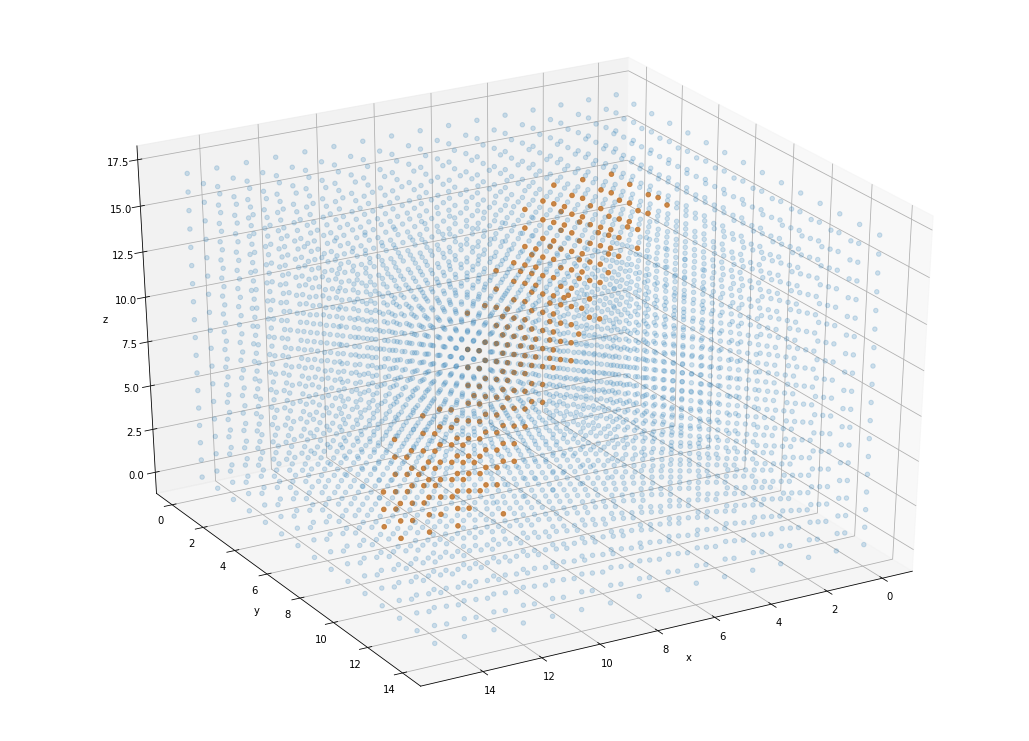

In [110]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,10))
ax = Axes3D(fig)

ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#for evt in wrong_class_evt_numu2:
#    plot_x_evt(evt)
plot_x_evt(1491)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()


In [95]:
X_numu.shape

(1541, 75, 16, 15, 18)

In [100]:
sum_X = np.asarray([np.sum(X_numu[evt],axis=0) for evt in range(X_numu.shape[0])])

In [101]:
sum_X.shape

(1541, 16, 15, 18)

In [103]:
X_numu[0][:,1]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, 

In [190]:
def zthits(evt):
    collection = []
    hits_index = np.nonzero(X[evt])
    for i in range(hits_index[0].shape[0]):
        collection.append((hits_index[0][i],hits_index[1][i], hits_index[2][i],hits_index[3][i], X[evt][hits_index][i]))
    return collection

In [191]:
zthits(0)

[(41, 5, 11, 1, 3),
 (44, 5, 10, 3, 3),
 (44, 5, 10, 5, 5),
 (45, 5, 10, 6, 9),
 (46, 5, 10, 7, 2)]

In [192]:
len(zthits(0))

5

In [271]:
X_numu.shape[0]

1541

In [343]:
X_numu.shape

(1541, 75, 16, 15, 18)

In [344]:
def zth_creation(X):
    n_events = X.shape[0]
    def zthits(evt):
        collection = []
        hits_index = np.nonzero(X[evt])
        for i in range(hits_index[0].shape[0]):
            collection.append((hits_index[0][i],hits_index[1][i], hits_index[2][i],hits_index[3][i], X[evt][hits_index][i]))
        return np.asarray(collection)
    zth = np.zeros((n_events, X.shape[1], X.shape[4]))
    coll = []
    for evt in range(n_events):
        coll.append(zthits(evt))
        for i in range(len(coll[evt])):
            zth[evt, coll[evt][i][0], coll[evt][i][3]] = coll[evt][i][4]
    return zth

In [345]:
zth_numu = zth_creation(X_numu)

In [316]:
zth_numu.shape

(1541, 75, 18)

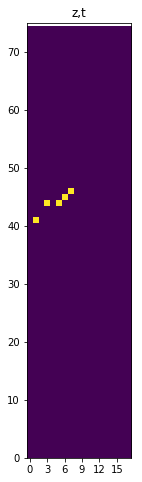

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(6,8))

plt.title("z,t")
plt.ylim(0,75)
plt.xticks(np.arange(0,19,3))
plt.imshow(zth_numu[0])

In [62]:
from keras.datasets import mnist

In [63]:
data= mnist.load_data()

11091968/11490434 [===========================>..] - ETA: 0s

In [64]:
data[0][0]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, 

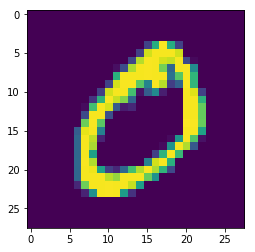

In [331]:
plt.imshow(data[0][0][1])

In [339]:
np.nonzero(data[0][0])

(array([    0,     1,     1, ..., 59997, 59998, 59999]),
 array([ 5,  9, 14, ..., 23, 17, 11]),
 array([21, 20, 20, ..., 15, 20, 11]))

In [340]:
data[0][0][np.nonzero(data[0][0])]

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [332]:
from numpy import reshape

In [333]:
resh = data[0][0].reshape(data[0][0].shape[0], 28, 28, 1)

In [334]:
resh/=255

In [67]:

X.shape

(1851, 75, 16, 15, 18)

In [68]:
x = X[0]

In [69]:
x.shape

(75, 16, 15, 18)

In [74]:
x[:,:,1].shape

(75, 16, 18)

In [75]:
X.shape

(1851, 75, 16, 15, 18)

In [98]:
def zth_creation(X):
    n_events = X.shape[0]
    def zthits(evt):
        collection = []
        hits_index = np.nonzero(X[evt])
        for i in range(hits_index[0].shape[0]):
            collection.append((hits_index[0][i],hits_index[1][i], hits_index[2][i],hits_index[3][i], X[evt][hits_index][i]))
        return collection
    zth = np.zeros((n_events, X.shape[1], X.shape[4]))
    
    for evt in range(n_events):
        coords = zthits(evt)
        for t, x, y, z, value in coords:
            zth[evt,t,z] += value
        
    return zth

In [99]:
z1 = zth_creation(X)

In [100]:
z1.shape

(1851, 75, 18)

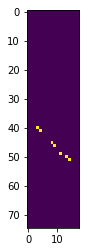

In [101]:
plt.imshow(z1[2])

In [96]:
z2 = np.sum(X, axis=(2,3))

In [102]:
np.all(z1==z2)

True

In [ ]:
plt.imshow(z2[0])

In [ ]:
from keras.layers import Lambda

zt = Lambda(lambda t: np.sum(t, axis=(2, 3))[..., np.newaxis])(input_layer)
xy = Lambda(lambda t: np.sum(t, axis=(1, 4))[..., np.newaxis])(input_layer)

# Block zt
x = Conv2D(...)(zt)
x = ...(x)

# Block xy
y = Conv2D(...)(xy)
y = ...(y)

# Merge
